# Modeling the number of Bids in eBay coin auctions

an Jupyter notebook for the book [Bayesian Learning](https://github.com/mattiasvillani/BayesianLearningBook/raw/main/pdf/BayesBook.pdf) by [Mattias Villani](http://mattiasvillani.com) 

The dataset contains data from 1000 auctions of collector coins. The dataset was collected and first analyzed in the article [Bayesian Inference in Structural Second-Price Common Value Auctions](https://www.jstor.org/stable/23243804?seq=1).

### Import modules and load the data

In [4]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(seed=123) # Set the seed for reproducibility

# Load the data
eBayData = pd.read_csv('https://github.com/mattiasvillani/BayesianLearningBook/raw/main/data/ebaybids/ebaybids.csv', sep = ',')
nBids = eBayData['nBids']

We will model these data using a **Poisson distribution**: 
$$y_1,...,y_n \vert \theta \overset{iid}{\sim} \mathrm{Poisson}(\theta).$$ 
with a conjugate **Gamma prior**\
$$\theta  \sim \mathrm{Gamma}(\alpha, \beta)$$\
so that the **posterior** is also Gamma:\
$$\theta \vert y_1,\ldots,y_n \sim \mathrm{Gamma}(\alpha + \sum_{i=1}^n y_i, \beta + n)$$

Number of data points = 1000
Sum of number of counts = 3635
Mean number of counts = 3.635
Prior mean = 4.0
Prior standard deviation = 2.8284271247461903
Equal tail 95% prior interval: (0.48441855708793014, 11.143286781877796)
Posterior mean = 3.635
Posterior standard deviation = 0.06027740643004339
Equal tail 95% posterior interval: (3.5179903738284697, 3.7542677655304297)


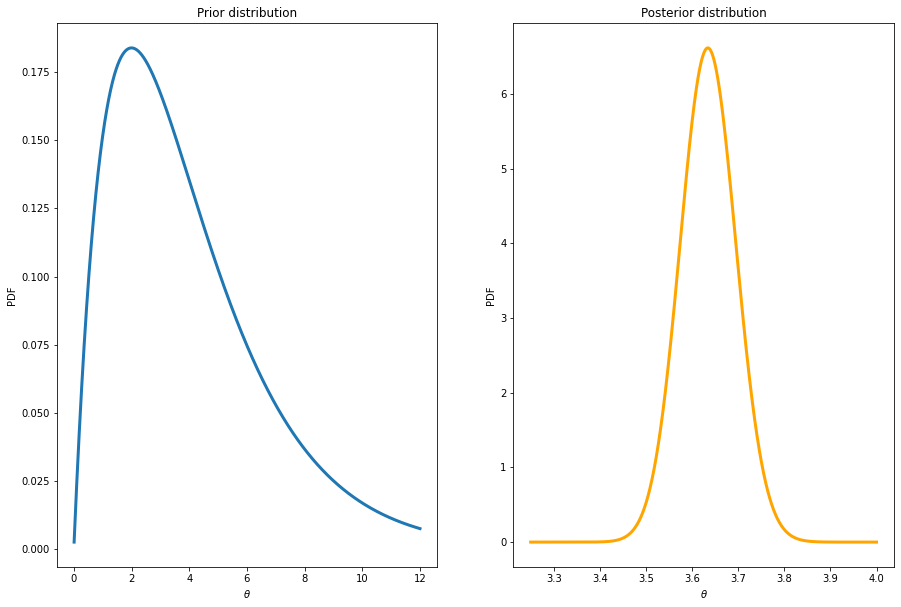

In [5]:
# Define the Gamma distribution in the rate parametrization
def gammaPDF(x, alpha, beta):
    return(sps.gamma.pdf(x, a = alpha, scale = 1/beta))


def PostPoisson(y, alphaPrior, betaPrior, thetaPriorGrid = None, thetaPostGrid = None):

    # Compute Prior density and posterior
    priorDens = gammaPDF(x = thetaPriorGrid, alpha = alphaPrior, beta = betaPrior)
    n = len(y)
    alphaPost = alphaPrior + np.sum(y)
    betaPost = betaPrior + n
    postDens = gammaPDF(x = thetaPostGrid, alpha = alphaPost, beta = betaPost)
    
    print('Number of data points = ' + str(len(y)))
    print('Sum of number of counts = ' + str(np.sum(y)))
    print('Mean number of counts = ' + str(np.mean(y)))
    print('Prior mean = ' + str(alphaPrior/betaPrior))
    print('Prior standard deviation = '+ str(np.sqrt(alphaPrior/(betaPrior**2))))
    print('Equal tail 95% prior interval: ' + str(sps.gamma.interval(0.95, a = alphaPrior, scale = 1/betaPrior)))  
    print('Posterior mean = ' + str(round(alphaPost/betaPost,3)))
    print('Posterior standard deviation = '+ str(np.sqrt(    (alphaPrior+np.sum(y))/  ((betaPrior+n)**2)  )    ))
    print('Equal tail 95% posterior interval: ' + str(sps.gamma.interval(0.95, a = alphaPost, scale = 1/betaPost)))  

    if (thetaPriorGrid.any() != None):
        fig, ax = plt.subplots(1, 2, figsize=(15, 10))
        h1, = ax[0].plot(thetaPriorGrid, priorDens, lw = 3);
        ax[0].set_xlabel(r'$\theta$');ax[0].set_ylabel('PDF');
        ax[0].set_title('Prior distribution');

        h2, = ax[1].plot(thetaPostGrid, postDens, lw = 3, color ="orange");
        ax[1].set_xlabel(r'$\theta$');ax[1].set_ylabel('PDF');
        ax[1].set_title('Posterior distribution');

alphaPrior = 2
betaPrior = 1/2
PostPoisson(y = nBids, alphaPrior = 2, betaPrior = 1/2,
            thetaPriorGrid = np.linspace(0.01,12,10000), thetaPostGrid = np.linspace(3.25,4,10000))

### Fit of the Poisson model
Let's plot the data along with the fitted Poisson model. We'll keep things simple and plot the fit for the posterior mean of $\theta$.

In [6]:
def plotPoissonFit(y, alphaPrior, betaPrior):
    
    # Plot data
    maxY = np.max(y)
    yGrid = np.arange(maxY)
    probs = [np.sum(y==k)/len(y) for k in range(maxY)]
    h1 = plt.bar(yGrid, probs, alpha = 0.3);
    plt.xlabel('y');plt.ylabel('PMF');
    plt.xticks(yGrid);
    plt.title('Fitted Poisson model based on posterior mean estimate');
    
    # Compute posterior mean
    n = len(y)
    alphaPost = alphaPrior + np.sum(y)
    betaPost = betaPrior + n
    postMean = alphaPost/betaPost
    
    # Plot the fit based on the posterior mean of theta
    poisFit = sps.poisson.pmf(yGrid, mu = postMean) 
    plt.plot(yGrid, poisFit, color = 'orange', lw = 3)

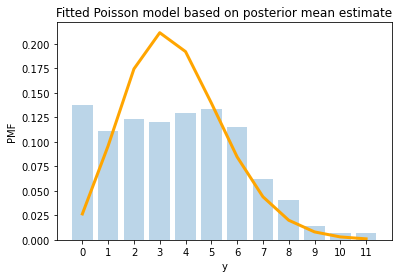

In [8]:
# Plot the fit for all bids
alphaPrior = 2
betaPrior = 1/2
plotPoissonFit(y = nBids, alphaPrior = alphaPrior, betaPrior = betaPrior)

Wow, that's are terrible fit! This data does not look at all like a Poisson distribution. What can we do? 

### Analyzing the auction with low and high reservation prices separately.

We will later model the number of bids using a Poisson *regression* where we take into account several explanatory variables. But, for now, let's split the auctions in two subsets:\
i) auctions with low reservation price in relation to the item's book value (MinBidShare<=0)\
ii) auctions with high reservation price in relation to the item's book value (MinBidShare>0)

Let's start with the 550 auction with low reservation prices. The prior for the auction with low reservation prices is set to $\theta \sim \mathrm{Gamma}(4,1/2)$ to reflect a belief that belief that such auctions are likely to attract more bids.

Number of data points = 550
Sum of number of counts = 2927
Mean number of counts = 5.321818181818182
Prior mean = 8.0
Prior standard deviation = 4.0
Equal tail 95% prior interval: (2.17973074725265, 17.534546139484647)
Posterior mean = 5.324
Posterior standard deviation = 0.0983446153216288
Equal tail 95% posterior interval: (5.13322503650632, 5.518717305739481)


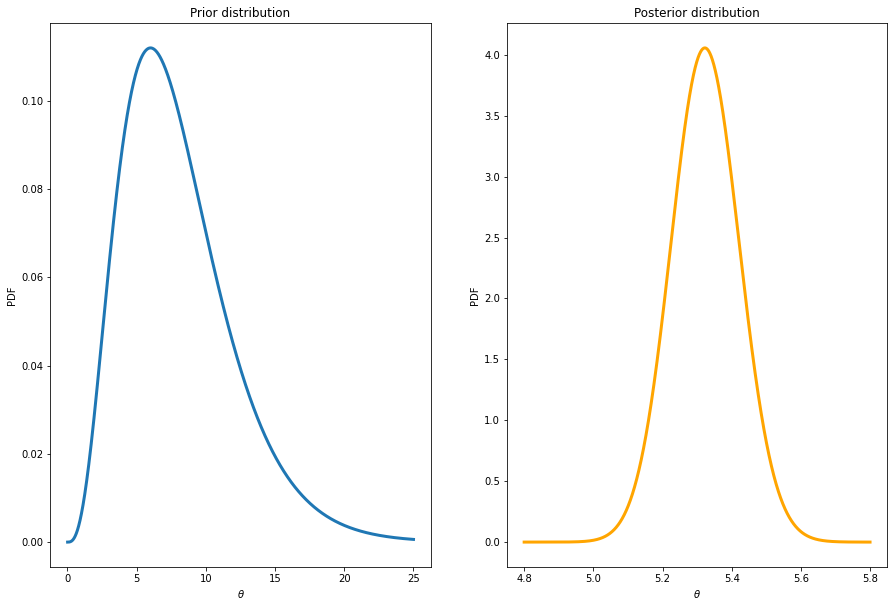

In [21]:
# Auctions with low reservation prices:
nBidsLow = nBids[eBayData['MinBidShare']<=0]

PostPoisson(y = nBidsLow, alphaPrior = 4, betaPrior = 1/2,
            thetaPriorGrid = np.linspace(0.01,25,10000), thetaPostGrid = np.linspace(4.8,5.8,10000))

As expected, the posterior for the mean number of bids is concentrated on a larger number of bids. People like to bid on items where the seller's reservation price is low.

Is the first for these auctions improved? Yes it is, although there is still room for improvement:

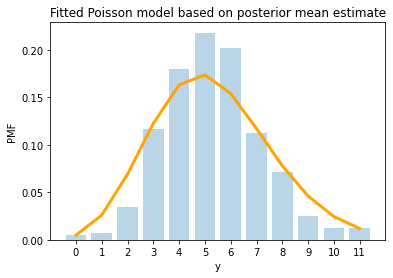

In [10]:
# Plot the fit for low bids
plotPoissonFit(y = nBidsLow, alphaPrior = alphaPrior, betaPrior = betaPrior)

Below are the results for the auction with high reservation bids. The prior is here set to $\theta \sim \mathrm{Gamma}(1,1/2)$ implying less on average. 

Number of data points = 450
Sum of number of counts = 708
Mean number of counts = 1.5733333333333333
Prior mean = 2.0
Prior standard deviation = 2.0
Equal tail 95% prior interval: (0.050635615968579795, 7.377758908227871)
Posterior mean = 1.574
Posterior standard deviation = 0.05910555807189499
Equal tail 95% posterior interval: (1.4600786825716714, 1.6917395497993104)


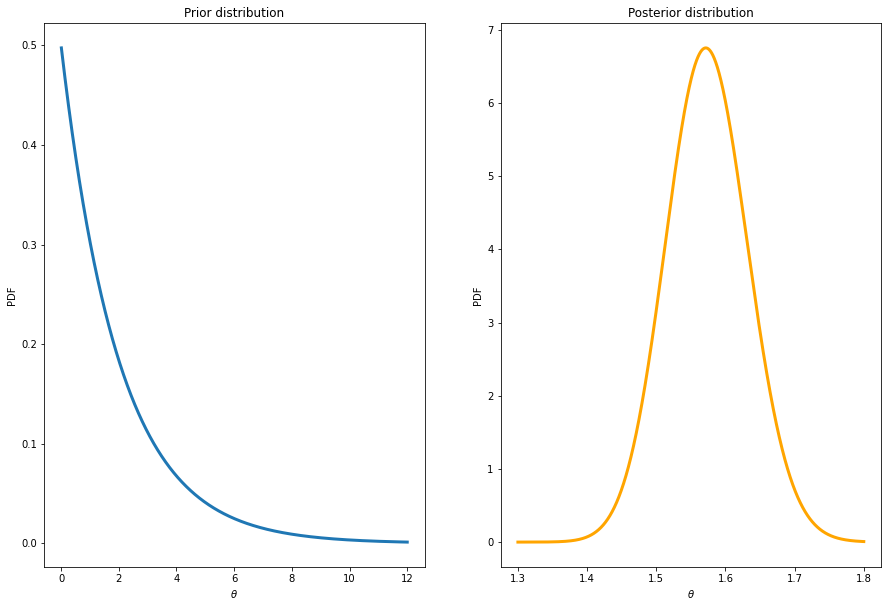

In [16]:
# Auctions with high reservation prices:
nBidsHigh = nBids[eBayData['MinBidShare']>0]

PostPoisson(y = nBidsHigh, alphaPrior = 1, betaPrior = 1/2,
            thetaPriorGrid = np.linspace(0.01,12,10000), thetaPostGrid = np.linspace(1.3,1.8,10000))

And the fit is not perfect for these bids, but better than before.

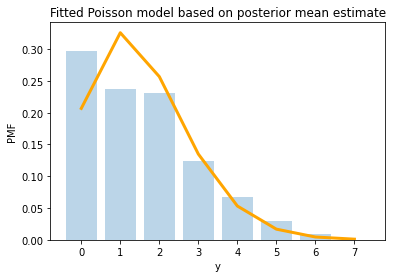

In [12]:
# Plot the fit for high bids
plotPoissonFit(y = nBidsHigh, alphaPrior = alphaPrior, betaPrior = betaPrior)

So, separating the bids into dataset with low and high reservation prices makes the Poisson model a lot better for the data. Later in the book, we will use a Poisson regression with 
reservation price as one of the features, which an even more fine grained analysis. 